In [1]:
import pandas as pd
from pathlib import Path

# project root (assumes this notebook is in notebooks/)
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATASET_CSV = ROOT / "data" / "cleaned_dataset.csv"

df = pd.read_csv(DATASET_CSV)
print("Rows:", len(df))
display(df.head())


Rows: 60


,audio,speaker_count,language
0,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
1,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en
2,../audios-wav/audios-ar/2_speakers_ar/two_spea...,2 Speakers,ar
3,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
4,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en


In [2]:
import torch, torchaudio
from pathlib import Path
from speechbrain.pretrained import SpeakerRecognition

# load model
spkrec = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

row = df.iloc[0]
audio_path = Path(row["audio"]).resolve()
print(f"Testing: {audio_path.name} | language={row['language']} | true={row['speaker_count']}")

# 1) load waveform
wav, sr = torchaudio.load(str(audio_path))           # [C, T]
if wav.shape[0] > 1:                                 # to mono
    wav = wav.mean(dim=0, keepdim=True)
wav = wav.squeeze(0)                                 # [T]

# 2) resample to 16k (ECAPA was trained at 16k)
if sr != 16000:
    wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    sr = 16000

# 3) batchify: [B, T]
wav = wav.unsqueeze(0)

# 4) encode
with torch.inference_mode():
    emb = spkrec.encode_batch(wav)                   # [B, D]
print("Embedding shape:", tuple(emb.shape))


c:\Users\AboMajed\audio-seg\Audio-AI\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\AboMajed\AppData\Local\Programs\Python\Python39\lib\inspect.py:746: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\AboMajed\AppData\Local\Temp\ipykernel_17196\3628608096.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import SpeakerRecognition
c:\Use

Testing: three_speakers7_ar.wav | language=ar | true=3 Speakers
Embedding shape: (1, 1, 192)


In [5]:
import time, re
from pathlib import Path
import numpy as np
import pandas as pd
import torch, torchaudio
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

RESULTS_DIR = (Path.cwd().parents[0] / "results") if Path.cwd().name == "notebooks" else (Path.cwd() / "results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV_SB = RESULTS_DIR / "speechbrain_predictions.csv"

def true_count(s):
    m = re.search(r"\d+", str(s))
    return int(m.group()) if m else np.nan

assert 'spkrec' in globals(), "Run the SpeechBrain smoke test cell first."

def to_mono_16k(audio_path: Path):
    wav, sr = torchaudio.load(str(audio_path))          # [C,T]
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0)                           # [T]
    else:
        wav = wav.squeeze(0)                            # [T]
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    return wav  # [T] at 16k

def embed_chunks(wav_16k: torch.Tensor, win_s=1.5, hop_s=0.75):
    """Split mono 16k waveform [T] -> embeddings [N,D]."""
    sr = 16000
    win = int(win_s * sr)
    hop = int(hop_s * sr)
    T = wav_16k.numel()
    if T < win:
        wav_16k = torch.nn.functional.pad(wav_16k, (0, win - T))
        T = wav_16k.numel()
    starts = range(0, T - win + 1, hop)
    embs = []
    with torch.inference_mode():
        for s in starts:
            chunk = wav_16k[s:s+win]            # [win]
            # encode_batch expects [B,T]
            e = spkrec.encode_batch(chunk.unsqueeze(0))  # -> [1,1,D] for ECAPA
            e = e.squeeze().cpu().numpy()      # -> [D]
            embs.append(e)
    return np.stack(embs, axis=0) if embs else None      # [N,D] or None

def choose_k(embs: np.ndarray, ks=(1,2,3)):
    """Pick k via silhouette; fallback to smallest inertia if needed."""
    best_k, best_score, best_labels = None, -np.inf, None
    inertias = {}
    for k in ks:
        if k == 1:
            labels = np.zeros(len(embs), dtype=int)
            centroid = embs.mean(axis=0, keepdims=True)
            inertia = float(((embs - centroid)**2).sum())
            inertias[k] = -inertia
            score = -1e9
        else:
            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
            labels = model.fit_predict(embs)
            if len(np.unique(labels)) < 2:
                score = -1e9
            else:
                score = float(silhouette_score(embs, labels))
        if score > best_score:
            best_k, best_score, best_labels = k, score, labels
    if best_k is None:
        best_k = 1
    return int(best_k)

rows, failures = [], 0
t0_all = time.time()

for idx, r in df.iterrows():
    audio_path = Path(r["audio"]).resolve()
    print(f"[{idx+1}/{len(df)}] {audio_path.name} ...", end=" ", flush=True)

    t0 = time.time()
    try:
        wav = to_mono_16k(audio_path)
        embs = embed_chunks(wav, win_s=1.5, hop_s=0.75)
        if embs is None or len(embs) < 2:
            pred = 1
            status = "✓ short→pred=1"
        else:
            pred = choose_k(embs, ks=(1,2,3))
            status = f"✓ pred={pred}"
    except Exception as e:
        pred = np.nan
        failures += 1
        status = f"✗ failed ({e})"
    dt = time.time() - t0

    print(f"{status} | {dt:.1f}s")

    rows.append({
        "audio": str(audio_path),
        "language": r["language"],
        "true_speakers": true_count(r["speaker_count"]),
        "pred_speakers": pred,
        "runtime_sec": dt,
    })

sb_df = pd.DataFrame(rows)
sb_df.to_csv(OUT_CSV_SB, index=False)

print(f"\nSaved: {OUT_CSV_SB}")
print(f"Total rows: {len(sb_df)} | Failures: {failures} | Total runtime: {(time.time()-t0_all)/60:.1f} min")
sb_df.head(8)


cuda
[1/60] three_speakers7_ar.wav ... ✓ pred=2 | 30.2s
[2/60] two_speakers5_en.wav ... ✓ pred=2 | 21.8s
[3/60] two_speakers7_ar.wav ... ✓ pred=2 | 17.1s
[4/60] three_speakers6_ar.wav ... ✓ pred=3 | 20.0s
[5/60] two_speakers8_en.wav ... ✓ pred=2 | 21.9s
[6/60] solo6_en.wav ... ✓ pred=2 | 14.2s
[7/60] two_speakers9_en.wav ... ✓ pred=2 | 22.1s
[8/60] solo10_en.wav ... ✓ pred=2 | 14.4s
[9/60] two_speakers10_en.wav ... ✓ pred=2 | 22.8s
[10/60] two_speakers1_en.wav ... ✓ pred=2 | 18.7s
[11/60] three_speakers4_en.wav ... ✓ pred=3 | 23.8s
[12/60] two_speakers4_ar.wav ... ✓ pred=2 | 20.1s
[13/60] two_speakers2_ar.wav ... ✓ pred=2 | 21.7s
[14/60] three_speakers6_en.wav ... ✓ pred=2 | 23.6s
[15/60] three_speakers2_en.wav ... ✓ pred=2 | 19.5s
[16/60] solo2_en.wav ... ✓ pred=3 | 14.3s
[17/60] solo8_ar.wav ... ✓ pred=2 | 16.4s
[18/60] solo7_ar.wav ... ✓ pred=2 | 16.1s
[19/60] three_speakers10_en.wav ... ✓ pred=2 | 29.3s
[20/60] solo6_ar.wav ... ✓ pred=2 | 17.2s
[21/60] solo9_ar.wav ... ✓ pred=2 | 1

,audio,language,true_speakers,pred_speakers,runtime_sec
0,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,2,30.219753
1,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,21.768936
2,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,2,2,17.124853
3,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,19.987467
4,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,21.902424
5,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,2,14.181167
6,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,22.066931
7,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,2,14.361278


=== SpeechBrain Evaluation ===
Accuracy         : 40.00%
Precision (macro): 30.11%
Recall (macro)   : 40.00%
F1-score (macro) : 32.29%

Per-class report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        20
           2      0.341     0.750     0.469        20
           3      0.562     0.450     0.500        20

    accuracy                          0.400        60
   macro avg      0.301     0.400     0.323        60
weighted avg      0.301     0.400     0.323        60



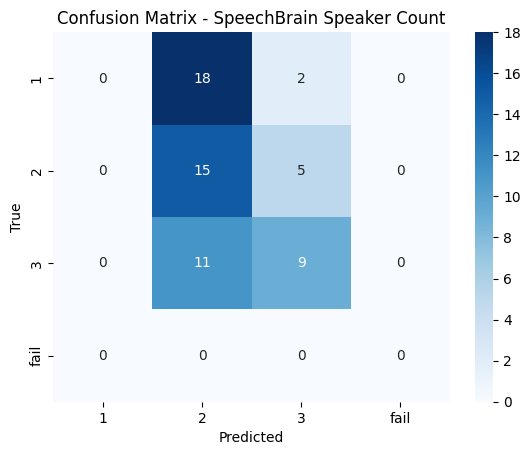

In [6]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from pathlib import Path

RESULTS_DIR = (Path.cwd().parents[0] / "results") if Path.cwd().name == "notebooks" else (Path.cwd() / "results")
OUT_CSV_SB = RESULTS_DIR / "speechbrain_predictions.csv"

pred_df = pd.read_csv(OUT_CSV_SB)

y_true = pred_df["true_speakers"].astype(int)
y_pred = pred_df["pred_speakers"].fillna(-1).astype(int)

print("=== SpeechBrain Evaluation ===")
print(f"Accuracy         : {accuracy_score(y_true, y_pred):.2%}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro', zero_division=0):.2%}")
print(f"Recall (macro)   : {recall_score(y_true, y_pred, average='macro', zero_division=0):.2%}")
print(f"F1-score (macro) : {f1_score(y_true, y_pred, average='macro', zero_division=0):.2%}\n")
print("Per-class report:")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,-1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,"fail"], yticklabels=[1,2,3,"fail"])
plt.title("Confusion Matrix - SpeechBrain Speaker Count")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
